<a href="https://colab.research.google.com/github/bioquaintum/pybrainorg/blob/main/02_running_a_simple_simulation_and_recording_spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a Simple Simulation and Recording Spikes

**Objective:** This notebook demonstrates how to take an organoid created with `pyneurorg` (as in Notebook 01), set up a simulation environment, run a basic simulation, and record/visualize neuronal spikes.

**Key `pyneurorg` components used:**
- `pyneurorg.organoid.Organoid`
- `pyneurorg.core.neuron_models`
- `pyneurorg.organoid.spatial`
- `pyneurorg.simulation.Simulator`: The class to orchestrate simulations.
- `pyneurorg.electrophysiology.brian_monitors`: Helper functions to set up monitors.
- `pyneurorg.visualization.spike_plotter`: For plotting raster plots.

In [ ]:
!pip3 install pyneurorg

## 1. Imports and Setup

Import necessary modules from `brian2`, `pyneurorg`, and `matplotlib`.

In [ ]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

from pyneurorg.organoid.organoid import Organoid
from pyneurorg.core import neuron_models
from pyneurorg.organoid import spatial
from pyneurorg.simulation.simulator import Simulator
from pyneurorg.electrophysiology import brian_monitors # For monitor setup functions
from pyneurorg.visualization import spike_plotter # For plotting

b2.prefs.codegen.target = 'numpy'
b2.seed(123) # Use a different seed or same for direct comparison
np.random.seed(123)

## 2. Create an Organoid

We'll recreate a simple organoid similar to Notebook 01. This time, we'll prepare it for some activity by setting an initial tonic current or ensuring the initial Vm is close to threshold for some neurons.

In [ ]:
simple_organoid = Organoid(name="SimOrganoid")

num_neurons = 50
lif_params_active = {
    'tau_m': 15*b2.ms,
    'v_rest': -70*b2.mV,
    'v_reset': -70*b2.mV,
    'v_thresh': -55*b2.mV,
    'R_m': 150*b2.Mohm,
    'I_tonic': 0.11*b2.nA, # A small tonic current to make them somewhat active
    'refractory_period': 3*b2.ms
}

neuron_positions = spatial.random_positions_in_cube(
    N=num_neurons,
    side_length=100
)

ng = simple_organoid.add_neurons(
    name="active_lif_neurons",
    num_neurons=num_neurons,
    model_name="LIFNeuron",
    model_params=lif_params_active,
    positions=neuron_positions,
    # Set slightly varied initial Vm to desynchronize initial spikes if I_tonic is high
    initial_values={'v': '-70*mV + rand()*5*mV'}
)

print(f"Created organoid: {simple_organoid} with neuron group: {ng.name}")

Created organoid: <Organoid 'SimOrganoid' with 1 neuron group(s) and 0 synapse group(s)> with neuron group: active_lif_neurons


## 3. Instantiate the Simulator

Create a `Simulator` instance, passing our organoid to it. We can also specify a `brian2_dt` for the simulation if needed (otherwise, Brian2's default is used).

In [ ]:
simulation_dt = 0.1*b2.ms
my_simulator = Simulator(organoid=simple_organoid, brian2_dt=simulation_dt)
print(my_simulator)

<Simulator for Organoid 'SimOrganoid' with 0 user-defined monitor(s). Network Status: Not Built>


## 4. Add Monitors for Recording

We need to tell the simulator what data to record. We'll add a `SpikeMonitor` to record all spikes from our neuron population and a `StateMonitor` to record the membrane potential (Vm) of a few selected neurons.

In [ ]:
# Add a SpikeMonitor
# The monitor_name is how we will retrieve its data later.
# target_group_name is the name we gave to our NeuronGroup in the Organoid.
spike_mon = my_simulator.add_recording(
    monitor_name="all_spikes",
    monitor_type="spike",
    target_group_name="active_lif_neurons",
    record=True # Record from all neurons in the group
)
print(f"Added SpikeMonitor: {spike_mon.name}")

# Add a StateMonitor for Vm of first 3 neurons
state_mon_vm = my_simulator.add_recording(
    monitor_name="vm_traces_subset",
    monitor_type="state",
    target_group_name="active_lif_neurons",
    variables='v', # Variable to record (must exist in neuron model)
    record=[0, 1, 2], # Record Vm for neurons with index 0, 1, and 2
    dt=0.5*b2.ms # Optional: record Vm at a specific dt (can be > simulation_dt)
)
print(f"Added StateMonitor for Vm: {state_mon_vm.name}")

print(f"Simulator monitors: {my_simulator.monitors.keys()}")

Added SpikeMonitor: pyb_mon_all_spikes_active_lif_neurons
Added StateMonitor for Vm: pyb_mon_vm_traces_subset_active_lif_neurons
Simulator monitors: dict_keys(['all_spikes', 'vm_traces_subset'])


## 5. Run the Simulation

Now we can run the simulation for a specified duration. The `Simulator` will build the Brian2 `Network` internally if it hasn't been built yet.

In [ ]:
simulation_duration = 200*b2.ms

print(f"Starting simulation for {simulation_duration}...")
my_simulator.run(simulation_duration, report='text', report_period=50*b2.ms)
print("Simulation finished.")

Starting simulation for 200. ms...
Starting simulation at t=0. s for a duration of 200. ms
31.6 ms (15%) simulated in < 1s, estimated < 1s remaining.
61.8 ms (30%) simulated in < 1s, estimated < 1s remaining.
90.7 ms (45%) simulated in < 1s, estimated < 1s remaining.
116.2 ms (58%) simulated in < 1s, estimated < 1s remaining.
143.3 ms (71%) simulated in < 1s, estimated < 1s remaining.
166.3 ms (83%) simulated in < 1s, estimated < 1s remaining.
191.6 ms (95%) simulated in < 1s, estimated < 1s remaining.
200. ms (100%) simulated in < 1s
Simulation finished.


## 6. Retrieve and Visualize Recorded Data

After the simulation, we can get the data from our monitors using the names we assigned.

### 6.1. Spike Data (Raster Plot)

Number of spikes recorded: 250
Example spike indices: [38 17 24  7 22]
Example spike times: [30.9 31.  31.1 31.2 31.4] ms


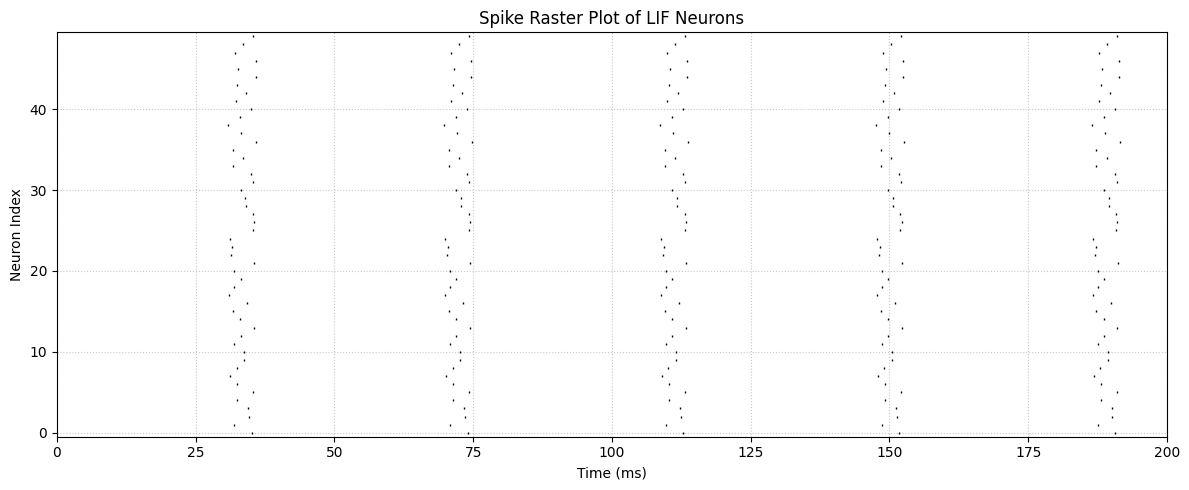

In [ ]:
recorded_spikes = my_simulator.get_data("all_spikes")

print(f"Number of spikes recorded: {len(recorded_spikes.i)}")
if len(recorded_spikes.i) > 0:
    print(f"Example spike indices: {recorded_spikes.i[:5]}")
    print(f"Example spike times: {recorded_spikes.t[:5]}")

    fig_raster, ax_raster = plt.subplots(figsize=(12, 5))
    spike_plotter.plot_raster(
        spike_indices=recorded_spikes.i,
        spike_times=recorded_spikes.t,
        duration=simulation_duration, # Pass the Brian2 Quantity (e.g., 100*b2.ms)
        ax=ax_raster,
        title=f"Spike Raster Plot of LIF Neurons"
        # time_unit_display=b2.ms # This is now default in the improved plot_raster
                                 # but can be specified if you want other units like b2.second
    )
    plt.tight_layout()
    plt.show()
else:
    print("No spikes were recorded.")

### 6.2. Membrane Potential (Vm) Traces

Shape of recorded Vm data (neurons, timepoints): (3, 400)
Time points for Vm: [0.  0.5 1.  1.5 2. ] ms ...


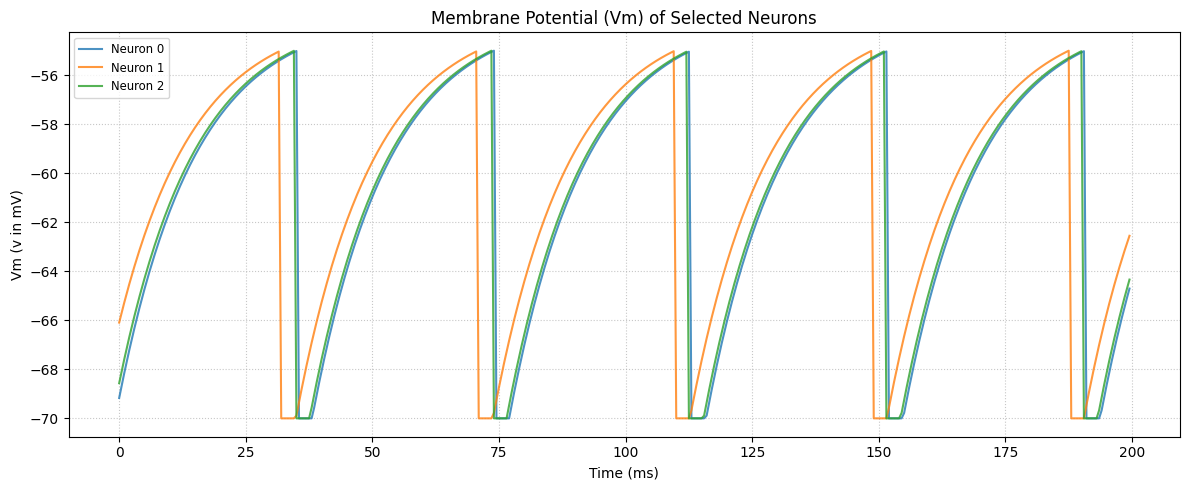

In [ ]:
recorded_vm = my_simulator.get_data("vm_traces_subset")

print(f"Shape of recorded Vm data (neurons, timepoints): {recorded_vm.v.shape}")
print(f"Time points for Vm: {recorded_vm.t[:5]} ...")

fig_vm, ax_vm = plt.subplots(figsize=(12, 5))
spike_plotter.plot_vm_traces(
    state_monitor=recorded_vm,
    # neuron_indices=None, # plot_vm_traces will plot all recorded if few, here we recorded 3
    ax=ax_vm,
    title="Membrane Potential (Vm) of Selected Neurons"
)
plt.tight_layout()
plt.show()

## 7. Summary

In this notebook, we have:
1. Created a `pyneurorg.Organoid` with a population of LIF neurons configured to be active.
2. Instantiated a `pyneurorg.simulation.Simulator`.
3. Added a `SpikeMonitor` and a `StateMonitor` to record activity.
4. Executed a simulation for a defined duration.
5. Retrieved the recorded spike and Vm data.
6. Visualized the spikes using a raster plot and Vm traces using `pyneurorg.visualization.spike_plotter`.

This forms the basic workflow for setting up and running simulations with `pyneurorg`.